In [1]:
import os
import email
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('C:/Users/benso/Desktop/Projects/UsableAI/Project/cleaned_enron.csv')
print(df['X-To'])

0         John J Lavorato <John J Lavorato/ENRON@enronXg...
1                                          Leah Van Arsdall
2                                                Greg Piper
3                                                Greg Piper
4                                            Joyce Teixeira
                                ...                        
489231    Loibl, Kori </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...
489232    Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...
489233    Doucet, Dawn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...
489234    Slone, Jeanie </O=ENRON/OU=NA/CN=RECIPIENTS/CN...
489235                   'Livia_Zufferli@Monitor.com@ENRON'
Name: X-To, Length: 489236, dtype: object


In [46]:
#Task 1: 
#split into train, valid and test. Train a model which predicts the sender email id.


#start off with 2 classes, move up from there.
#2 classes = 2 most frequent email senders
df.rename(columns={'X-From': 'From', 'X-To': 'To'}, inplace=True)

class0,class1 = list(df['From'].value_counts().index)[:2]
print(class0)
print(class1)


Kay Mann
Vince J Kaminski


In [ ]:
#one more data cleaning thing.


In [47]:
n_per_class = 1280
messages_0 = df.query('From==@class0')['body'].sample(frac=1)[:n_per_class].values
messages_1 = df.query('From==@class1')['body'].sample(frac=1)[:n_per_class].values

In [48]:
max_features = 2048
embed_dim = 256
maxlen = 256

from tensorflow.keras.preprocessing.text import Tokenizer

messages_all = messages_0+messages_1
np.random.shuffle(messages_all)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(messages_all)
word_index = tokenizer.word_index # This dictionary translates each word to its index (corresponding number)

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Transform messages into sequences of numbers corresponding to its particular words
seqs_0 = tokenizer.texts_to_sequences(messages_0)
seqs_1 = tokenizer.texts_to_sequences(messages_1)

# Pad sequences, i.e. make them exactly 256 tokens long (as described above)
seqs_0 = pad_sequences(seqs_0, maxlen=maxlen)
seqs_1 = pad_sequences(seqs_1, maxlen=maxlen)

# Concatenate the sequences
seqs_all = np.concatenate([seqs_0, seqs_1], axis=0)

# Create and concatenate the labels
labels_0 = np.zeros(shape=(seqs_0.shape[0]))
labels_1 = np.ones(shape=(seqs_1.shape[0]))
labels_all = np.concatenate([labels_0, labels_1], axis=0)

In [50]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(seqs_all,labels_all,stratify=labels_all)

In [51]:
from tensorflow.keras import models, layers, optimizers, losses, metrics, utils, applications, callbacks


model = models.Sequential(layers=[
    layers.Embedding(input_dim=max_features, output_dim=embed_dim, input_length=maxlen),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=True, dropout=.1, recurrent_dropout=.1)),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=False, dropout=.1, recurrent_dropout=.1)),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.2),
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 256)          524288    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256, 64)           55680     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [18]:
#import h5py
from keras.models import load_model



model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

EPOCHS = 5

history = model.fit(
    X_train, y_train,
    epochs = EPOCHS, batch_size=64,
    shuffle = True,
    verbose = 1
)

model.save('last_model.h5') # Save the final model

Epoch 1/5
30/30 [==============================] - 61s 2s/step - loss: 1.6356 - acc: 0.6565
Epoch 2/5
30/30 [==============================] - 62s 2s/step - loss: 1.1205 - acc: 0.8538
Epoch 3/5
30/30 [==============================] - 68s 2s/step - loss: 0.8183 - acc: 0.9167
Epoch 4/5
30/30 [==============================] - 63s 2s/step - loss: 0.5974 - acc: 0.9575
Epoch 5/5
30/30 [==============================] - 62s 2s/step - loss: 0.4525 - acc: 0.9625


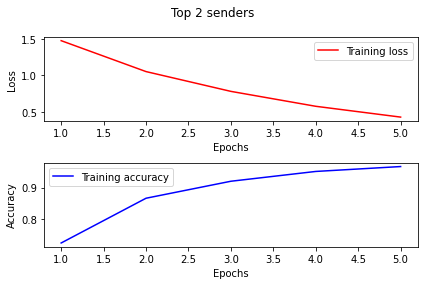

In [61]:
#The first epoch already had an accuracy of 0.93


train_loss = history.history['loss']

train_acc = history.history['acc']

fig, ax = plt.subplots(2)
ax[0].plot(np.arange(1,EPOCHS+1), train_loss, 'r', label='Training loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(np.arange(1,EPOCHS+1), train_acc, 'b', label='Training accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.suptitle('Top 2 senders')
plt.tight_layout()
plt.savefig("C:/Users/benso/Desktop/Projects/UsableAI/Project/2class_model.png")

plt.show()



In [29]:
#lets see predictions
preds = model.predict(X_test)
preds = preds.reshape(1,-1)
npreds = preds.tolist()
newpreds = [item for sublist in npreds for item in sublist]

In [67]:
######################################################################################################
#Let's do this for the top 20 senders, see if the accuracy is still okay

nclass0,nclass1,nclass2,nclass3,nclass4,nclass5,nclass6,nclass7,nclass8,nclass9,nclass10,nclass11,nclass12,nclass13,nclass14,nclass15,nclass16,nclass17,nclass18,nclass19 = list(df['From'].value_counts().index)[:20]
print(nclass0)
print(nclass1)
print(nclass2)
print(nclass3)
print(nclass4)
print(nclass5)
print(nclass6)
print(nclass7)
print(nclass9)
print(nclass10)

Kay Mann
Vince J Kaminski
Jeff Dasovich
Enron Announcements
Tana Jones
Sara Shackleton
Chris Germany
Steven J Kean
Kate Symes
Eric Bass


In [68]:
n_per_class_20 = 1280
n_messages_0 = df.query('From==@nclass0')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_1 = df.query('From==@nclass1')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_2 = df.query('From==@nclass2')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_3 = df.query('From==@nclass3')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_4 = df.query('From==@nclass4')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_5 = df.query('From==@nclass5')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_6 = df.query('From==@nclass6')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_7 = df.query('From==@nclass7')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_8 = df.query('From==@nclass8')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_9 = df.query('From==@nclass9')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_10 = df.query('From==@nclass10')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_11 = df.query('From==@nclass11')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_12 = df.query('From==@nclass12')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_13 = df.query('From==@nclass13')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_14 = df.query('From==@nclass14')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_15 = df.query('From==@nclass15')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_16 = df.query('From==@nclass16')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_17 = df.query('From==@nclass17')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_18 = df.query('From==@nclass18')['body'].sample(frac=1)[:n_per_class_20].values
n_messages_19 = df.query('From==@nclass19')['body'].sample(frac=1)[:n_per_class_20].values

In [81]:
max_features = 512
embed_dim = 128
maxlen = 200

from tensorflow.keras.preprocessing.text import Tokenizer

messages_all = n_messages_0+n_messages_1+n_messages_2+n_messages_3+n_messages_4+n_messages_5+n_messages_6+n_messages_7+n_messages_8+n_messages_9+n_messages_10+n_messages_11+n_messages_12+n_messages_13+n_messages_14+n_messages_15+n_messages_16+n_messages_17+n_messages_18+n_messages_19
np.random.shuffle(messages_all)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(messages_all)
word_index = tokenizer.word_index # This dictionary translates each word to its index (corresponding number)

In [82]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Transform messages into sequences of numbers corresponding to its particular words
seqs_0 = tokenizer.texts_to_sequences(n_messages_0)
seqs_1 = tokenizer.texts_to_sequences(n_messages_1)
seqs_2 = tokenizer.texts_to_sequences(n_messages_2)
seqs_3 = tokenizer.texts_to_sequences(n_messages_3)
seqs_4 = tokenizer.texts_to_sequences(n_messages_4)
seqs_5 = tokenizer.texts_to_sequences(n_messages_5)
seqs_6 = tokenizer.texts_to_sequences(n_messages_6)
seqs_7 = tokenizer.texts_to_sequences(n_messages_7)
seqs_8 = tokenizer.texts_to_sequences(n_messages_8)
seqs_9 = tokenizer.texts_to_sequences(n_messages_9)
seqs_10 = tokenizer.texts_to_sequences(n_messages_10)
seqs_11 = tokenizer.texts_to_sequences(n_messages_11)
seqs_12 = tokenizer.texts_to_sequences(n_messages_12)
seqs_13 = tokenizer.texts_to_sequences(n_messages_13)
seqs_14 = tokenizer.texts_to_sequences(n_messages_14)
seqs_15 = tokenizer.texts_to_sequences(n_messages_15)
seqs_16 = tokenizer.texts_to_sequences(n_messages_16)
seqs_17 = tokenizer.texts_to_sequences(n_messages_17)
seqs_18 = tokenizer.texts_to_sequences(n_messages_18)
seqs_19 = tokenizer.texts_to_sequences(n_messages_19)



# Pad sequences, i.e. make them exactly 256 tokens long (as described above)
seqs_0 = pad_sequences(seqs_0, maxlen=maxlen)
seqs_1 = pad_sequences(seqs_1, maxlen=maxlen)
seqs_2 = pad_sequences(seqs_2, maxlen=maxlen)
seqs_3 = pad_sequences(seqs_3, maxlen=maxlen)
seqs_4 = pad_sequences(seqs_4, maxlen=maxlen)
seqs_5 = pad_sequences(seqs_5, maxlen=maxlen)
seqs_6 = pad_sequences(seqs_6, maxlen=maxlen)
seqs_7 = pad_sequences(seqs_7, maxlen=maxlen)
seqs_8 = pad_sequences(seqs_8, maxlen=maxlen)
seqs_9 = pad_sequences(seqs_9, maxlen=maxlen)
seqs_10 = pad_sequences(seqs_10, maxlen=maxlen)
seqs_11 = pad_sequences(seqs_11, maxlen=maxlen)
seqs_12 = pad_sequences(seqs_12, maxlen=maxlen)
seqs_13 = pad_sequences(seqs_13, maxlen=maxlen)
seqs_14 = pad_sequences(seqs_14, maxlen=maxlen)
seqs_15 = pad_sequences(seqs_15, maxlen=maxlen)
seqs_16 = pad_sequences(seqs_16, maxlen=maxlen)
seqs_17 = pad_sequences(seqs_17, maxlen=maxlen)
seqs_18 = pad_sequences(seqs_18, maxlen=maxlen)
seqs_19 = pad_sequences(seqs_19, maxlen=maxlen)



# Concatenate the sequences
seqs_all = np.concatenate([seqs_0, seqs_1,seqs_2,seqs_3,seqs_4,seqs_5,seqs_6,seqs_7,seqs_8,seqs_9,seqs_10,seqs_11,seqs_12,seqs_13,seqs_14,seqs_15,seqs_16,seqs_17,seqs_18,seqs_19], axis=0)

# Create and concatenate the labels
labels_0 = np.zeros(shape=(seqs_0.shape[0]))
labels_1 = np.ones(shape=(seqs_1.shape[0]))
labels_2 = np.full((seqs_2.shape[0]), 2)
labels_3 = np.full((seqs_3.shape[0]), 3)
labels_4 = np.full((seqs_4.shape[0]), 4)
labels_5 = np.full((seqs_5.shape[0]), 5)
labels_6 = np.full((seqs_6.shape[0]), 6)
labels_7 = np.full((seqs_7.shape[0]), 7)
labels_8 = np.full((seqs_8.shape[0]), 8)
labels_9 = np.full((seqs_9.shape[0]), 9)
labels_10 = np.full((seqs_10.shape[0]), 10)
labels_11 = np.full((seqs_11.shape[0]), 11)
labels_12 = np.full((seqs_12.shape[0]), 12)
labels_13 = np.full((seqs_13.shape[0]), 13)
labels_14 = np.full((seqs_14.shape[0]), 14)
labels_15 = np.full((seqs_15.shape[0]), 15)
labels_16 = np.full((seqs_16.shape[0]), 16)
labels_17 = np.full((seqs_17.shape[0]), 17)
labels_18 = np.full((seqs_18.shape[0]), 18)
labels_19 = np.full((seqs_19.shape[0]), 19)

labels_all = np.concatenate([labels_0, labels_1,labels_2,labels_3,labels_4,labels_5,labels_6,labels_7,labels_8,labels_9,labels_10,labels_11,labels_12,labels_13,labels_14,labels_15,labels_16,labels_17,labels_18,labels_19], axis=0)

#labels_all = np.concatenate([labels_0, labels_1], axis=0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(seqs_all,labels_all,stratify=labels_all)

In [87]:
model = models.Sequential(layers=[
    layers.Embedding(input_dim=max_features, output_dim=embed_dim, input_length=maxlen),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=True, dropout=.1, recurrent_dropout=.1)),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=False, dropout=.1, recurrent_dropout=.1)),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.2),
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(20, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          65536     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200, 64)           31104     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                18816     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [89]:
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

EPOCHS = 5

history = model.fit(
    X_train, y_train,
    epochs = EPOCHS, batch_size=64,
    shuffle = True,
    verbose = 1
)

model.save('last_model_10classes.h5') # Save the final model

Epoch 1/5
300/300 [==============================] - 144s 465ms/step - loss: 3.2626 - acc: 0.2590
Epoch 2/5
300/300 [==============================] - 172s 574ms/step - loss: 2.1117 - acc: 0.4320
Epoch 3/5
300/300 [==============================] - 175s 583ms/step - loss: 1.5819 - acc: 0.5657
Epoch 4/5
300/300 [==============================] - 165s 551ms/step - loss: 0.9242 - acc: 0.7757
Epoch 5/5
300/300 [==============================] - 167s 555ms/step - loss: 0.7179 - acc: 0.8247


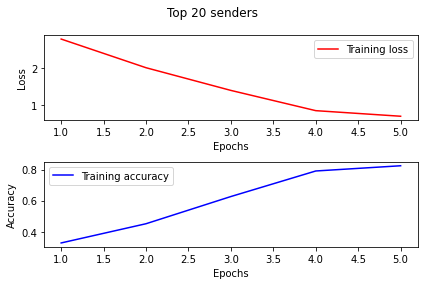

In [90]:
train_loss = history.history['loss']

train_acc = history.history['acc']

fig, ax = plt.subplots(2)
ax[0].plot(np.arange(1,EPOCHS+1), train_loss, 'r', label='Training loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(np.arange(1,EPOCHS+1), train_acc, 'b', label='Training accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.suptitle('Top 20 senders')
plt.tight_layout()
plt.savefig("C:/Users/benso/Desktop/Projects/UsableAI/Project/20class_model.png")

plt.show()